In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning, module="joblib")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings('ignore', category=UserWarning, message="Line Search failed")

In [5]:
#load data and preprocess
data = pd.read_csv('/content/drive/My Drive/labelled_data.csv').fillna(0)
print(data.head())
print(data.isnull().sum())

   Unnamed: 0     Name        FC     logFC    logCPM   P-Value       FDR  \
0           0  KRT16P5 -1.474275 -0.560006 -2.065784  0.423250  0.645529   
1           1  KRT16P3 -1.158475 -0.212227  0.698547  0.598622  0.779482   
2           2  KRT16P2  1.785481  0.836313  3.744968  0.060200  0.211667   
3           3  KRT16P6 -2.534136 -1.341494  0.404997  0.023716  0.123727   
4           4    CRHBP  1.441891  0.527962 -0.015277  0.034942  0.153404   

   SCLC  NSCLC  
0   0.0    0.0  
1   0.0    0.0  
2   0.0    0.0  
3   0.0    0.0  
4   0.0    0.0  
Unnamed: 0    0
Name          0
FC            0
logFC         0
logCPM        0
P-Value       0
FDR           0
SCLC          0
NSCLC         0
dtype: int64


In [6]:
#feature selection
features = data[['FC', 'logFC', 'P-Value']]
targets = {'NSCLC': data['NSCLC'], 'SCLC': data['SCLC']}

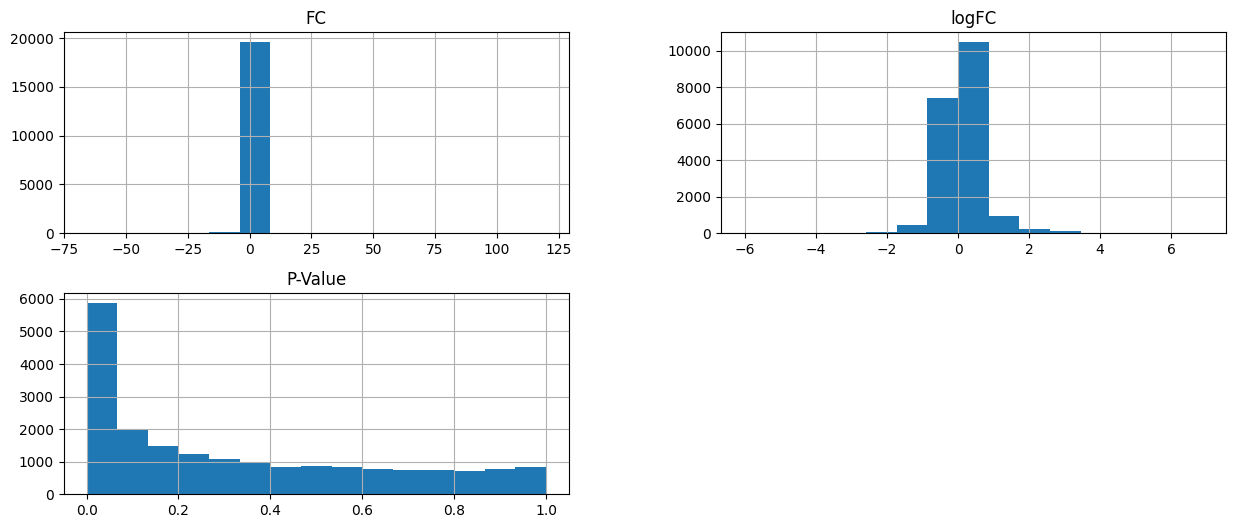

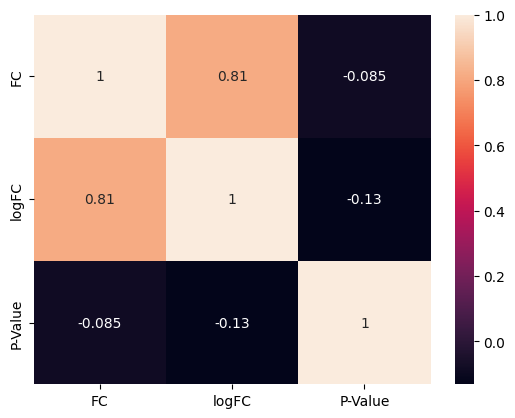

In [7]:
#EDA
#histograms and correlation matrix
features.hist(bins=15, figsize=(15, 6), layout=(2, 2))
plt.show()
sns.heatmap(features.corr(), annot=True)
plt.show()

In [8]:
#SMOTE and data splitting
def split_and_resample(features, target, test_size=0.4, random_state=42):
    x_train, x_temp, y_train, y_temp = train_test_split(features, target, test_size=test_size, random_state=random_state)
    smote = SMOTE()
    x_train_res, y_train_res = smote.fit_resample(x_train, y_train)
    x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=random_state)
    return x_train_res, x_test, x_val, y_train_res, y_test, y_val

data_nsclc = split_and_resample(features, targets['NSCLC'])
data_sclc = split_and_resample(features, targets['SCLC'])

In [14]:
#random forest pipeline
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(class_weight='balanced', n_jobs=-1))  #n_jobs=-1 uses all available cores
])

#parameter grid for random forest
param_grid_rf = {
    'rf__n_estimators': [100, 200, 300],
    'rf__criterion': ['gini', 'entropy'],
    'rf__max_depth': [None, 10, 20],
    # 'rf__min_samples_split': [2, 5, 10],
    # 'rf__min_samples_leaf': [1, 2, 4],
    # 'rf__max_features': ['sqrt', 'log2'],
    # 'rf__max_leaf_nodes': [None, 50, 100],
    # 'rf__min_impurity_decrease': [0.0, 0.1, 0.2],
    # 'rf__bootstrap': [True, False],
    # 'rf__oob_score': [False, True],
    # 'rf__random_state': [None, 42, 123],
    # 'rf__verbose': [0, 1],
    # 'rf__warm_start': [False, True],
    # 'rf__class_weight': [None, 'balanced'],
    # 'rf__ccp_alpha': [0.0, 0.1, 0.2],
    # 'rf__max_samples': [None, 0.7, 0.8]
}


In [15]:
#function for GridSearchCV and model evaluation
def evaluate_random_forest(data, param_grid):
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(data[0], data[3])  #fit on training data
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_rf = pipeline.set_params(**best_params)
    best_rf.fit(data[0], data[3])  #refit on training data
    y_val_pred = best_rf.predict(data[2])  #predict on validation data
    report = classification_report(data[5], y_val_pred)
    return best_params, best_score, report

In [16]:
#evaluate for NSCLC
best_params_nsclc, best_score_nsclc, report_nsclc = evaluate_random_forest(data_nsclc, param_grid_rf)
print("Best Parameters for NSCLC:", best_params_nsclc)
print("Best F1 Score for NSCLC:", best_score_nsclc)
print("Classification Report for NSCLC (Validation Data):\n", report_nsclc)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters for NSCLC: {'rf__criterion': 'gini', 'rf__max_depth': 20, 'rf__n_estimators': 300}
Best F1 Score for NSCLC: 0.8060112286989544
Classification Report for NSCLC (Validation Data):
               precision    recall  f1-score   support

         0.0       0.97      0.75      0.85      3820
         1.0       0.05      0.35      0.08       136

    accuracy                           0.74      3956
   macro avg       0.51      0.55      0.47      3956
weighted avg       0.94      0.74      0.82      3956



In [17]:
#evaluate for SCLC
best_params_sclc, best_score_sclc, report_sclc = evaluate_random_forest(data_sclc, param_grid_rf)
print("Best Parameters for SCLC:", best_params_sclc)
print("Best F1 Score for SCLC:", best_score_sclc)
print("Classification Report for SCLC (Validation Data):\n", report_sclc)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters for SCLC: {'rf__criterion': 'entropy', 'rf__max_depth': None, 'rf__n_estimators': 300}
Best F1 Score for SCLC: 0.7914272990009976
Classification Report for SCLC (Validation Data):
               precision    recall  f1-score   support

         0.0       0.95      0.75      0.84      3769
         1.0       0.05      0.27      0.09       187

    accuracy                           0.73      3956
   macro avg       0.50      0.51      0.46      3956
weighted avg       0.91      0.73      0.80      3956

